# Overview
- This notebook is the Watson Studio notebook for the Advanced Data Science Capstone project of Coursera.
- The topic of this project is the "IEEE-CIS Fraud Detection" challenge from Kaggle, more information about the dataset and the competition can be found at https://www.kaggle.com/c/ieee-fraud-detection/
- The Machine Learning model in this Notebook is developped using the tensorflow/keras integrated in the Watson Studio Notebook. In addition, other libraries are used for the data analysis, graph display, data preprocessing:
    + numpy
    + pandas
    + scikit-learn
    + matplotlib
    + seaborn
- This model is developped using only the data from the train_transaction.csv, meaning just have of the given data.
- In order to evaluate the performance of the model, F1_score function is developped, 

# Load the dataset from the Cloud Data Object

In [ ]:
# The code was removed by Watson Studio for sharing.

# Import the libraries and cleansing (using OneHotEncoding) and Normalize the data

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import copy
import os

In [3]:
dataset_transaction.columns

Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5',
       ...
       'V330', 'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 'V337', 'V338',
       'V339'],
      dtype='object', length=394)

In [4]:
float_columns = dataset_transaction.columns[np.where(dataset_transaction.dtypes == np.dtype('float64'))].to_list()
int_columns = dataset_transaction.columns[np.where(dataset_transaction.dtypes == np.dtype('int64'))].to_list()
obj_columns = dataset_transaction.columns[np.where(dataset_transaction.dtypes == np.dtype('O'))].to_list()

skip_int_columns = ['TransactionID', 'isFraud']
for column in skip_int_columns:
  int_columns.remove(column)

skip_obj_colums = ['']

In [5]:
def normalization_data(X, indices):
  X_out = copy.copy(X)
  X_temp = X[indices]
  X_out.iloc[indices] = (X_temp-np.mean(X_temp))/(np.max(X_temp)-np.min(X_temp))
  X_out.iloc[np.where(np.isnan(X_out))[0]] = 0
  return np.min(X_temp), np.max(X_temp), np.mean(X_temp), X_out.astype('float16')

In [6]:
# Task 1: Detect the columns with NaN and code it with an extra features
# Task 2: Apply normalizationn
# Task 3: Remove irrelevant columns

cache = dict()
#dataset_transaction = copy.copy(data_backup)

#dataset_transaction.pop()

for column in float_columns:
  # Set to float 16
  dataset_transaction[column].astype('float16')

  # Code the NaN feature
  if np.any(np.isnan(dataset_transaction[column].values)):
    dataset_transaction[column + "_NaN_Code"] = np.isnan(dataset_transaction[column].values).astype('int8')
  
  # Normalization
  X = dataset_transaction[column]
  indices = np.where(np.isnan(dataset_transaction[column]) == False)[0]
  cache[column+'_min'], cache[column+'_max'], cache[column+'_mean'], dataset_transaction[column] = normalization_data(X, indices)

In [7]:
dataset_transaction.head(5)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330_NaN_Code,V331_NaN_Code,V332_NaN_Code,V333_NaN_Code,V334_NaN_Code,V335_NaN_Code,V336_NaN_Code,V337_NaN_Code,V338_NaN_Code,V339_NaN_Code
0,2987000,0,86400,-0.002083,W,13926,0.000000,-0.024384,discover,-0.418213,...,1,1,1,1,1,1,1,1,1,1
1,2987001,0,86401,-0.003321,W,2755,0.082886,-0.024384,mastercard,-0.709961,...,1,1,1,1,1,1,1,1,1,1
2,2987002,0,86469,-0.002380,W,4663,0.254883,-0.024384,visa,-0.242920,...,1,1,1,1,1,1,1,1,1,1
3,2987003,0,86499,-0.002663,W,18132,0.408936,-0.024384,mastercard,-0.600586,...,1,1,1,1,1,1,1,1,1,1
4,2987004,0,86506,-0.002663,H,4497,0.302979,-0.024384,mastercard,-0.709961,...,0,0,0,0,0,0,0,0,0,0


In [8]:
for column in int_columns:
  # Set to int 32
  dataset_transaction[column].astype('int32')

  # Code the NaN feature
  if np.any(np.isnan(dataset_transaction[column].values)):
    dataset_transaction[column + "_NaN_Code"] = np.isnan(dataset_transaction[column].values).astype('int8')
  
  # Normalization
  X = dataset_transaction[column]
  indices = np.where(np.isnan(dataset_transaction[column]) == False)[0]
  cache[column+'_min'], cache[column+'_max'], cache[column+'_mean'], dataset_transaction[column] = normalization_data(X, indices)

In [9]:
dataset_transaction.head(5)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330_NaN_Code,V331_NaN_Code,V332_NaN_Code,V333_NaN_Code,V334_NaN_Code,V335_NaN_Code,V336_NaN_Code,V337_NaN_Code,V338_NaN_Code,V339_NaN_Code
0,2987000,0,-0.463379,-0.002083,W,0.231445,0.000000,-0.024384,discover,-0.418213,...,1,1,1,1,1,1,1,1,1,1
1,2987001,0,-0.463379,-0.003321,W,-0.410645,0.082886,-0.024384,mastercard,-0.709961,...,1,1,1,1,1,1,1,1,1,1
2,2987002,0,-0.463379,-0.002380,W,-0.301025,0.254883,-0.024384,visa,-0.242920,...,1,1,1,1,1,1,1,1,1,1
3,2987003,0,-0.463379,-0.002663,W,0.473389,0.408936,-0.024384,mastercard,-0.600586,...,1,1,1,1,1,1,1,1,1,1
4,2987004,0,-0.463379,-0.002663,H,-0.310547,0.302979,-0.024384,mastercard,-0.709961,...,0,0,0,0,0,0,0,0,0,0


In [10]:
from sklearn.preprocessing import OneHotEncoder
for column in obj_columns:
  ohc = OneHotEncoder()
  dataset_transaction.loc[np.where(dataset_transaction[column].isnull())[0], column] = 'Null'
  encoded = ohc.fit_transform(dataset_transaction[column].values.reshape(-1,1)).toarray()    
  pd_encoded = pd.DataFrame(encoded.astype('int8'), columns=[column+"_"+str(i) for i in range(len(np.unique(dataset_transaction[column].astype('str'))))])
  dataset_transaction = pd.concat([dataset_transaction, pd_encoded], axis=1)

for column in obj_columns:
  try:
    dataset_transaction.pop(column)
  except KeyError:
    pass
dataset_transaction.head(5)

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,...,M6_2,M7_0,M7_1,M7_2,M8_0,M8_1,M8_2,M9_0,M9_1,M9_2
0,2987000,0,-0.463379,-0.002083,0.231445,0.000000,-0.024384,-0.418213,0.055145,0.002167,...,1,0,1,0,0,1,0,0,1,0
1,2987001,0,-0.463379,-0.003321,-0.410645,0.082886,-0.024384,-0.709961,0.077881,0.002167,...,1,0,1,0,0,1,0,0,1,0
2,2987002,0,-0.463379,-0.002380,-0.301025,0.254883,-0.024384,-0.242920,0.089233,0.002167,...,0,1,0,0,1,0,0,1,0,0
3,2987003,0,-0.463379,-0.002663,0.473389,0.408936,-0.024384,-0.600586,0.421143,0.002167,...,0,0,1,0,0,1,0,0,1,0
4,2987004,0,-0.463379,-0.002663,-0.310547,0.302979,-0.024384,-0.709961,0.293701,0.002167,...,0,0,1,0,0,1,0,0,1,0


In [11]:
# Double check again Null and Nan
print(np.any(np.isnan(dataset_transaction)), np.any(dataset_transaction.isnull()))

False False


# Apply Seaborn to analyze the processed data and detect removable features

In [12]:
colums_to_analyze = ['isFraud', 'TransactionDT', 'TransactionAmt', 'P_emaildomain_0', 'P_emaildomain_1', 'P_emaildomain_2', 'P_emaildomain_3', 'P_emaildomain_4', 'addr1', 'addr2', 'dist1', 'dist2']
analyzing_data = dataset_transaction[colums_to_analyze]

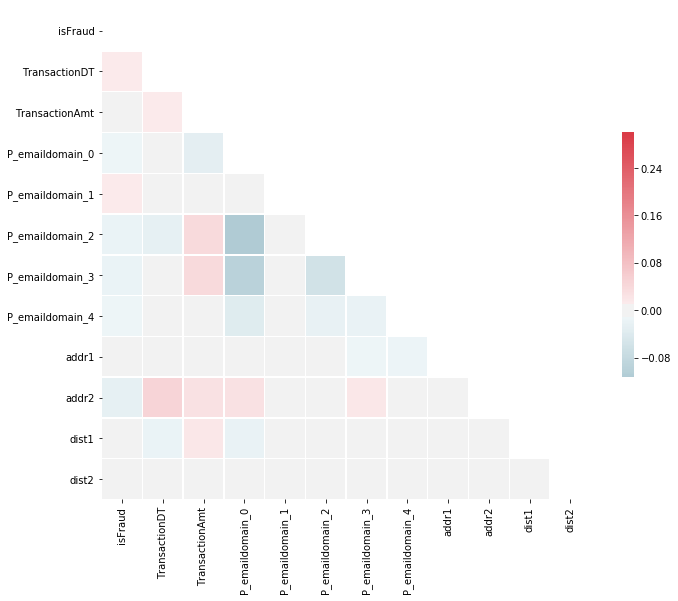

In [13]:
corr = analyzing_data.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Create the train/val dataset

In [14]:
# Remove the irrelevant columns
dataset = copy.copy(dataset_transaction)
dataset.pop('TransactionID')
dataset.head(5)

,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,...,M6_2,M7_0,M7_1,M7_2,M8_0,M8_1,M8_2,M9_0,M9_1,M9_2
0,0,-0.463379,-0.002083,0.231445,0.000000,-0.024384,-0.418213,0.055145,0.002167,-0.009674,...,1,0,1,0,0,1,0,0,1,0
1,0,-0.463379,-0.003321,-0.410645,0.082886,-0.024384,-0.709961,0.077881,0.002167,0.000000,...,1,0,1,0,0,1,0,0,1,0
2,0,-0.463379,-0.002380,-0.301025,0.254883,-0.024384,-0.242920,0.089233,0.002167,0.016388,...,0,1,0,0,1,0,0,1,0,0
3,0,-0.463379,-0.002663,0.473389,0.408936,-0.024384,-0.600586,0.421143,0.002167,0.000000,...,0,0,1,0,0,1,0,0,1,0
4,0,-0.463379,-0.002663,-0.310547,0.302979,-0.024384,-0.709961,0.293701,0.002167,0.000000,...,0,0,1,0,0,1,0,0,1,0


In [15]:
from sklearn.model_selection import train_test_split

Y = dataset['isFraud']
dataset.pop('isFraud')
X = dataset

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

print(X_train.shape, Y_train.shape, X_test.shape)

(472432, 903) (472432,) (118108, 903)


In [ ]:
# Check the imbalance
plt.subplot(211)
plt.hist(Y_train, bins=[0,1,2])

plt.subplot(212)
plt.hist(Y_test, bins=[0,1,2])

fraud_count = np.unique(Y_train, return_counts=True)
print("Percentage of Fraud: " + str(round(fraud_count[1][1]/np.sum(fraud_count[1])*100,2)) + "%")

# Downsampling/Upsampling to minimize the imbalance 

In [16]:
downsampling_factor = 10
indices_1 = np.argwhere(np.array(Y_train)==1)
indices_0_new = np.argwhere(np.array(Y_train)==0)
indices = np.arange(0,len(indices_0_new),downsampling_factor)
indices_0_new = indices_0_new[indices]

print(indices_0_new.shape)
indices_0_new = np.concatenate((indices_0_new, indices_1), axis=0)
print(indices_0_new.shape)


X_to_train = np.array(X_train)[indices_0_new]
Y_to_train = np.array(Y_train)[indices_0_new]


X_to_train = np.reshape(X_to_train, (X_to_train.shape[0], X_to_train.shape[2]))
Y_to_train = np.squeeze(Y_to_train, axis=1)
print(X_to_train.shape, Y_to_train.shape)

(45591, 1)
(62116, 1)
(62116, 903) (62116,)


Percentage of Fraud: 26.6%


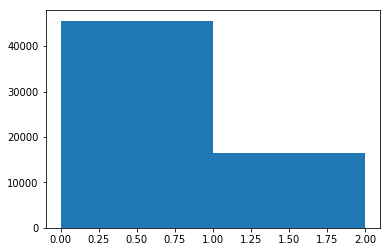

In [18]:
plt.hist(Y_to_train, bins=[0,1,2])

fraud_count = np.unique(Y_to_train, return_counts=True)
print("Percentage of Fraud: " + str(round(fraud_count[1][1]/np.sum(fraud_count[1])*100,2)) + "%")

# Create the model using NN

In [21]:
import keras
from keras.layers import Dense, Flatten, Dropout, BatchNormalization
from keras import Sequential
from keras.regularizers import l1_l2
from keras.optimizers import Adam, SGD

Using TensorFlow backend.


In [25]:
def create_model(dense1=128, dense2=64, dropout_rate=0.4, l1_rate=0.001, l2_rate=0.001, init_std=0.01, lr_value=0.001):
  out_model = Sequential()
  out_model.add(Dense(dense1, activation="relu", input_shape=(X_train.shape[1],),
                      kernel_initializer=keras.initializers.RandomUniform(minval=-init_std, maxval=init_std),
                      kernel_regularizer=l1_l2(l1=l1_rate, l2=l2_rate)))
  out_model.add(Dense(dense1, activation="relu",
                      kernel_initializer=keras.initializers.RandomUniform(minval=-init_std, maxval=init_std),
                      kernel_regularizer=l1_l2(l1=l1_rate, l2=l2_rate)))
  out_model.add(Dropout(dropout_rate))

  out_model.add(Dense(dense2, activation="relu", 
                      kernel_initializer=keras.initializers.RandomUniform(minval=-init_std, maxval=init_std),
                      kernel_regularizer=l1_l2(l1=l1_rate, l2=l2_rate)))
  out_model.add(Dense(dense2, activation="relu",
                      kernel_initializer=keras.initializers.RandomUniform(minval=-init_std, maxval=init_std),
                      kernel_regularizer=l1_l2(l1=l1_rate, l2=l2_rate)))
  out_model.add(Dropout(dropout_rate))

  out_model.add(Dense(1, activation="sigmoid"))

  out_model.compile(
            optimizer=Adam(lr=lr_value, beta_1=0.9, beta_2=0.999, amsgrad=True),
            loss='binary_crossentropy',
            metrics=['binary_accuracy'])
  
  return out_model

In [27]:
my_model = create_model(dense1=128, dense2=64, dropout_rate=0.4, l1_rate=0, l2_rate=0, init_std=0.05, lr_value=0.0001)
my_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 128)               115712    
_________________________________________________________________
dense_7 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_9 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 65        
Total para

# Perform the training and using the callbacks to optimize the performance of the final model

In [ ]:
BATCH_SIZE = 128
NB_EPOCH = 1000

early_stop = keras.callbacks.EarlyStopping(
    monitor='val_binary_accuracy', patience=50, verbose=0, mode='auto',
    baseline=None)

best_model_hold = keras.callbacks.ModelCheckpoint(
    filepath='./best_model.pb', monitor='val_binary_accuracy', verbose=1, save_best_only=True,
    save_weights_only=False, mode='auto')

history = my_model.fit(X_to_train, Y_to_train, 
             batch_size=BATCH_SIZE, epochs=NB_EPOCH,
             validation_split=0.2, shuffle=True,
             callbacks=[early_stop, best_model_hold])

Instructions for updating:
Use tf.cast instead.
Train on 49692 samples, validate on 12424 samples
Epoch 1/1000
49692/49692 [==============================] - 511s 10ms/step - loss: 0.3214 - binary_accuracy: 0.9164 - val_loss: 2.1192 - val_binary_accuracy: 0.0000e+00

Epoch 00001: val_binary_accuracy improved from -inf to 0.00000, saving model to ./best_model.pb
Epoch 2/1000
49692/49692 [==============================] - 551s 11ms/step - loss: 0.2387 - binary_accuracy: 0.9186 - val_loss: 1.9917 - val_binary_accuracy: 0.1780

Epoch 00002: val_binary_accuracy improved from 0.00000 to 0.17796, saving model to ./best_model.pb
Epoch 3/1000
49692/49692 [==============================] - 553s 11ms/step - loss: 0.2180 - binary_accuracy: 0.9311 - val_loss: 1.7611 - val_binary_accuracy: 0.2603

Epoch 00003: val_binary_accuracy improved from 0.17796 to 0.26030, saving model to ./best_model.pb
Epoch 4/1000
49692/49692 [==============================] - 548s 11ms/step - loss: 0.2104 - binary_accurac

# The lost and the training cuvre

In [ ]:
plt.subplot(211)
plt.plot(history.history["loss"], '-b')
plt.plot(history.history["val_loss"], '-r')

plt.subplot(212)
plt.plot(history.history["binary_accuracy"], '-b')
plt.plot(history.history["val_binary_accuracy"], '-r')

my_model = new_model = keras.models.load_model('./best_model.pb')

# F1_score function to tune the threshold

In [ ]:
def precision_cal(y_pred, y_ref):
  pre = 0
  if np.any(y_pred == 1):
    indices_positive = np.argwhere(y_pred == 1)
    true_pos = np.sum(y_ref[indices_positive])

    if true_pos == len(indices_positive):
      false_pos = 0
    else:
      false_pos = len(indices_positive) - true_pos

    pre = true_pos/(true_pos + false_pos)
  return pre

def recall_cal(y_pred, y_ref):
  recall = 0
  if np.any(y_pred == 1):
    indices_positive = np.argwhere(y_pred == 1)
    true_pos = np.sum(y_ref[indices_positive])

    fals_neg = np.sum(y_ref[np.argwhere(y_pred == 0)])
       
    recall = true_pos/(true_pos + fals_neg)

  return recall

def F1_score(model, X_test, y_ref, test_size, threshold=0.5):
  test_size = 12800
  y_pred = (model.predict(X_test[:test_size], batch_size=128)>threshold).astype(int)
  y_pred = np.squeeze(y_pred, axis=1)
  y_pred[7] = 1
  y_pred[23] = 1
  #pred_dist = np.unique(y_pred.astype(int), return_counts=True)
  #correct_prediction = np.unique(y_pred == np.expand_dims(Y_test[:test_size], axis=1), return_counts=True)
  #print(pred_dist, correct_prediction[0])
  
  precision = precision_cal(y_pred, np.array(Y_test[:test_size]))
  recall = recall_cal(y_pred, np.array(Y_test[:test_size]))

  return precision, recall, 2*precision*recall/(precision+recall)



In [ ]:
# Tune the threshold values
f1_final = []
best_threshold = 0
best_f1 = 0
for i in np.arrange(0.2, 0.1, 0.8):
    pre, re, f1 = F1_score(my_model, X_test, Y_test, test_size=12800, threshold=i)
    if len(f1_final) > 0:
        if f1 < best_f1:
            best_threshold = i
            best_f1 = f1
    else:
        best_f1 = f1
        best_threshold = i
        
    f1_final.append(f1)
    
print("Best threshold value: " + str(best_threshold) + "; F1 score is: " + str(best_f1))

In [ ]:
plt.plot(f1_final)

# Have a look at the prediction using the X_test

In [ ]:
my_model.evaluate(X_test, Y_test, verbose=1)

In [ ]:
prediction = my_model.predict(X_test)

In [ ]:
prediction = np.squeeze(prediction, axis=1)

plt.subplot(211)
plt.hist(Y_test, bins=[0,1,2])

plt.subplot(212)
plt.hist(prediction, bins=[0,1,2])



fraud_predict = np.unique((prediction>0.5).astype('int'), return_counts=True)
fraud_real = np.unique(Y_test, return_counts=True)
print("Percentage of Fraud: " + str(round(fraud_predict[1][1]/np.sum(fraud_predict[1])*100,2)) + "% " + str(round(fraud_real[1][1]/np.sum(fraud_real[1])*100,2)) + "%")
